# Análisis de características y DBSCAN para clustering

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sweetviz as sv

In [116]:
# Lectura del archivo
raw_df = pd.read_csv('../data/raw/dengue-raw.csv')

# Seleccionar columnas irrelevantes
columnas_irrelevantes = ['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'HABLA_LENGUA_INDIG', 'INDIGENA','ENTIDAD_UM_NOTIF',
            'MUNICIPIO_UM_NOTIF', 'INSTITUCION_UM_NOTIF', 'DICTAMEN', 'TOMA_MUESTRA', 'ENTIDAD_ASIG', 'MUNICIPIO_ASIG'
            ]

# Limpiamos
df = raw_df.drop(columnas_irrelevantes, axis=1)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['FECHA_SIGN_SINTOMAS'] = pd.to_datetime(df['FECHA_SIGN_SINTOMAS'])


In [117]:
df

,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,FECHA_SIGN_SINTOMAS,TIPO_PACIENTE,HEMORRAGICOS,DIABETES,HIPERTENSION,ENFERMEDAD_ULC_PEPTICA,ENFERMEDAD_RENAL,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,RESULTADO_PCR,ESTATUS_CASO
0,1,12,23,5,2024-01-07,1,2,2,2,2,2,2,2,2,2,3,2
1,2,24,31,50,2024-01-08,1,2,2,2,2,2,2,2,2,2,3,2
2,2,18,12,35,2024-01-01,1,2,2,2,2,2,2,2,2,2,5,1
3,1,62,27,13,2024-01-07,1,2,2,2,2,2,2,2,2,2,5,2
4,2,45,30,193,2024-01-09,1,2,2,2,2,2,2,2,2,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52536,1,66,25,12,2024-01-20,1,2,1,2,2,2,2,2,2,2,5,3
52537,2,18,12,77,2024-01-18,1,2,2,2,2,2,2,2,2,2,5,1
52538,1,38,17,4,2024-01-22,1,2,2,2,2,2,2,2,2,2,5,1
52539,2,9,12,38,2024-01-21,1,2,2,2,2,2,2,2,2,2,5,1


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50079 entries, 0 to 52540
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SEXO                    50079 non-null  int64         
 1   EDAD_ANOS               50079 non-null  int64         
 2   ENTIDAD_RES             50079 non-null  int64         
 3   MUNICIPIO_RES           50079 non-null  int64         
 4   FECHA_SIGN_SINTOMAS     50079 non-null  datetime64[ns]
 5   TIPO_PACIENTE           50079 non-null  int64         
 6   HEMORRAGICOS            50079 non-null  int64         
 7   DIABETES                50079 non-null  int64         
 8   HIPERTENSION            50079 non-null  int64         
 9   ENFERMEDAD_ULC_PEPTICA  50079 non-null  int64         
 10  ENFERMEDAD_RENAL        50079 non-null  int64         
 11  INMUNOSUPR              50079 non-null  int64         
 12  CIRROSIS_HEPATICA       50079 non-null  int64      

In [119]:
# Creamos un EDA automático para exploración de los datos
report = sv.analyze(df)
report.show_html("informe.html")

                                             |          | [  0%]   00:00 -> (? left)

Report informe.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Interpretación del EDA

<div style="text-align:center;">
    <img src="../reports/figures/Edad.jpg" alt="Edad" style="width:800px;"/>
</div>


La edad es una variable que sigue una distribución que se asemeja a una lognormal ya que presenta un sesgo positivo, con media de 27 años. El 75% de los datos corresponden con pacientes de edad menor o igual a 48. Además, la edad presenta una correlación positiva y baja con diabetes e hipertensión (pero es de las correlaciones más altas encontradas), lo cual se explica precisamente con que estos padecimientos son más comunes en las personas mayores.


<div style="text-align:center;">
    <img src="../reports/figures/TipoPaciente.jpg" alt="TipoPaciente" style="width:800px;"/>
</div>


La mayoría de los casos, casi el 80%, son tratados de manera ambulatoria en lugar de hospitalizados. La correlación más alta encontrada fue con la defunción, también podemos interpretar que los casos más graves son hospitalizados y esto tiene una asociación con la defunción.

<div style="text-align:center;">
    <img src="../reports/figures/Comorbilidad.jpg" alt="Comorbilidad" style="width:800px;"/>
</div>


La comorbilidad es realmente muy baja, menos del 1% presenta alguna de las comorbilidades registradas.

<div style="text-align:center;">
    <img src="../reports/figures/Defuncion.jpg" alt="Defuncion" style="width:600px;"/>
</div>


La defunción por dengue es muy baja, menos del 1%.

<div style="text-align:center;">
    <img src="../reports/figures/PCR.jpg" alt="PCR" style="width:600px;"/>
</div>

En las pruebas de PCR notamos que la mayoría de los casos (etiqueta 5) son sin serotipo aislado, lo cual indica que la mayoría de los casos o no se identifica el tipo de dengue o se descarta. Además, vemos que la etiqueta 3 es la que se repite más veces indicando que ese serotipo específico es el más común. 

Recordemos además que el resultado de esta prueba determina el estatus del caso, que puede irse modificando de probable a confirmado/descartado.

<div style="text-align:center;">
    <img src="../reports/figures/EstatusCaso.jpg" alt="EstatusCaso" style="width:800px;"/>
</div>

Podemos ver que la mayoría de los casos se mantienen como probable dengue (etiqueta 1), y los casos confirmados (2) y descartados (3) se mantienen algo parejos. Es de esperar que mantenga cierto tipo de correlación con el resultado PCR ya que este dicta el estatus.

<div style="text-align:center;">
    <img src="../reports/figures/Correlacion.jpg" alt="Correlacion" style="width:800px;"/>
</div>

En este análisis de correlación y explicabilidad podemos identificar que: 
- El Estatus Caso proporciona gran información sobre el resultado de la prueba PCR.
- El tipo de paciente explica moderadamente la defunción.
- El diabetes e hipertensión explican moderadamente la edad.

## Análisis temporal

In [120]:
historial_casos = df.groupby(df['FECHA_SIGN_SINTOMAS']).size().reset_index(name='Numero de Casos')
historial_casos

,FECHA_SIGN_SINTOMAS,Numero de Casos
0,2024-01-01,612
1,2024-01-02,534
2,2024-01-03,515
3,2024-01-04,513
4,2024-01-05,565
...,...,...
99,2024-04-09,379
100,2024-04-10,286
101,2024-04-11,137
102,2024-04-12,35


In [121]:
# Crear el gráfico de líneas con Plotly
fig = px.line(historial_casos, x='FECHA_SIGN_SINTOMAS', y='Numero de Casos', 
              title='Histórico de casos', labels={'FECHA_SIGN_SINTOMAS': 'Fecha', 'Numero de Casos': 'Número de Casos'})

# Mostrar el gráfico
fig.show()

A partir de esta visualización podemos ver que los datos están presentando cierta tendencia hacia la baja, esto puede deberse ya sea a la efectividad de las campañas de concientización o bien a la situación actual de sequía que está sufriendo casi todo el país. 

Un detalle que deberíamos mencionar sobre la caída que aparentemente se ve a mediados de abril es que esta fecha es tan cercana a la última actualización del dataset que es de esperarse que se tengan pocos casos registrados ya que el periodo de incubación del virus va de 4-10 días aproximadamente. 

## DBSCAN

In [122]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [123]:
# Convertir cada fecha a un timestamp
df['timestamp'] = df['FECHA_SIGN_SINTOMAS'].apply(lambda x: x.timestamp())

In [124]:
df.head()

,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,FECHA_SIGN_SINTOMAS,TIPO_PACIENTE,HEMORRAGICOS,DIABETES,HIPERTENSION,ENFERMEDAD_ULC_PEPTICA,ENFERMEDAD_RENAL,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,RESULTADO_PCR,ESTATUS_CASO,timestamp
0,1,12,23,5,2024-01-07,1,2,2,2,2,2,2,2,2,2,3,2,1.704586e+09
1,2,24,31,50,2024-01-08,1,2,2,2,2,2,2,2,2,2,3,2,1.704672e+09
2,2,18,12,35,2024-01-01,1,2,2,2,2,2,2,2,2,2,5,1,1.704067e+09
3,1,62,27,13,2024-01-07,1,2,2,2,2,2,2,2,2,2,5,2,1.704586e+09
4,2,45,30,193,2024-01-09,1,2,2,2,2,2,2,2,2,2,5,3,1.704758e+09


In [125]:
df_timestamp = df.copy()
df_timestamp = df_timestamp.drop(columns=["FECHA_SIGN_SINTOMAS"])
df_timestamp.head()

,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,HEMORRAGICOS,DIABETES,HIPERTENSION,ENFERMEDAD_ULC_PEPTICA,ENFERMEDAD_RENAL,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,RESULTADO_PCR,ESTATUS_CASO,timestamp
0,1,12,23,5,1,2,2,2,2,2,2,2,2,2,3,2,1.704586e+09
1,2,24,31,50,1,2,2,2,2,2,2,2,2,2,3,2,1.704672e+09
2,2,18,12,35,1,2,2,2,2,2,2,2,2,2,5,1,1.704067e+09
3,1,62,27,13,1,2,2,2,2,2,2,2,2,2,5,2,1.704586e+09
4,2,45,30,193,1,2,2,2,2,2,2,2,2,2,5,3,1.704758e+09


In [126]:
# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_timestamp)

In [127]:
# Aplicar DBSCAN
epsilon = 0.6  # radio máximo de la vecindad
min_samples =100  # número mínimo de puntos requeridos para formar un cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(data_scaled)

In [128]:
# Asignar los clusters de vuelta a los datos originales
df['cluster'] = clusters

In [129]:
# Resultados
df.head()

,SEXO,EDAD_ANOS,ENTIDAD_RES,MUNICIPIO_RES,FECHA_SIGN_SINTOMAS,TIPO_PACIENTE,HEMORRAGICOS,DIABETES,HIPERTENSION,ENFERMEDAD_ULC_PEPTICA,ENFERMEDAD_RENAL,INMUNOSUPR,CIRROSIS_HEPATICA,EMBARAZO,DEFUNCION,RESULTADO_PCR,ESTATUS_CASO,timestamp,cluster
0,1,12,23,5,2024-01-07,1,2,2,2,2,2,2,2,2,2,3,2,1.704586e+09,-1
1,2,24,31,50,2024-01-08,1,2,2,2,2,2,2,2,2,2,3,2,1.704672e+09,-1
2,2,18,12,35,2024-01-01,1,2,2,2,2,2,2,2,2,2,5,1,1.704067e+09,0
3,1,62,27,13,2024-01-07,1,2,2,2,2,2,2,2,2,2,5,2,1.704586e+09,-1
4,2,45,30,193,2024-01-09,1,2,2,2,2,2,2,2,2,2,5,3,1.704758e+09,-1


In [130]:
df['cluster'].value_counts()

cluster
-1     25550
 1     10451
 0      9405
 6      1322
 3       821
 10      325
 7       305
 2       274
 5       274
 15      261
 9       210
 12      165
 4       162
 14      162
 8       156
 13      135
 11      101
Name: count, dtype: int64

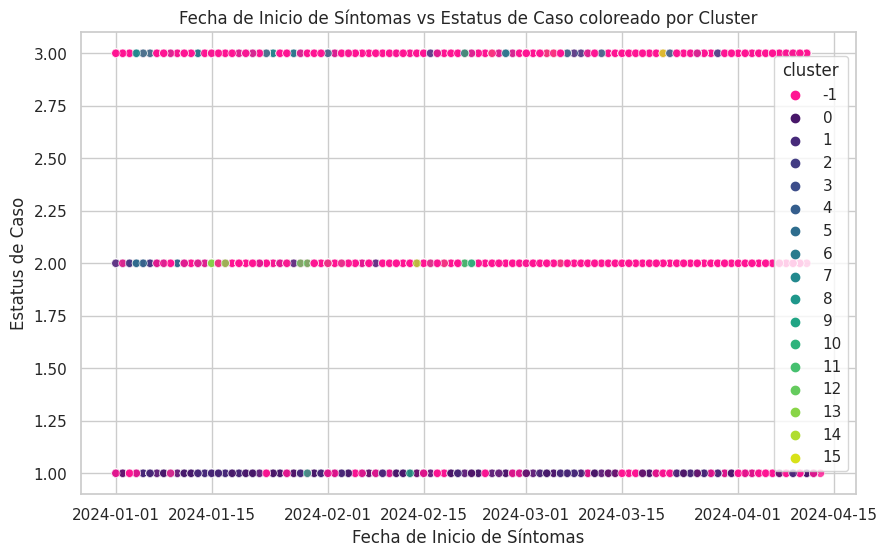

In [131]:
# Configuración de Seaborn
sns.set(style="whitegrid")

# Definir la paleta de colores personalizada
custom_palette = sns.color_palette(["deeppink"] + sns.color_palette("viridis", len(df['cluster'].unique()) - 1))

# Crear la gráfica de dispersión con Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='FECHA_SIGN_SINTOMAS', y='ESTATUS_CASO', hue='cluster', 
                palette=custom_palette, alpha=0.8, legend='full')
plt.title('Fecha de Inicio de Síntomas vs Estatus de Caso coloreado por Cluster')
plt.xlabel('Fecha de Inicio de Síntomas')
plt.ylabel('Estatus de Caso')
plt.show()

In [132]:
# Graficar con Plotly Express
# fig = px.scatter(df, x='FECHA_SIGN_SINTOMAS', y='ESTATUS_CASO', color='cluster', 
#                  #size='EDAD_ANOS', 
#                  hover_data=['ENTIDAD_RES', 'MUNICIPIO_RES'], 
#                  title='Fecha de Inicio de Síntomas vs Estatus de Caso coloreado por Cluster y tamaño por Edad')
# fig.show()

DBSCAN encontró 15 clusters y recordemos que lo que etiqueta como -1 corresponde con los datos que identificó como ruido, vemos que la mayoría de los datos confirmados y descartados los clasifica como ruido, esto no resultó de relevancia para nuestro análisis. 